In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
# Sampler
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
# Keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from keras.models import Model
# for resize an img
from skimage.transform import rescale, resize
import skimage.io
from PIL import Image
# Training and testing with train_test_split
from sklearn.model_selection import train_test_split
# Validation model
from sklearn.metrics import confusion_matrix , classification_report

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
import warnings # tf needs to learn to stfu
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
FilePath = "/content/drive/MyDrive/HAM10000 dataset/hmnist_28_28_RGB.csv"
dataSet = pd.read_csv(FilePath)
Label = dataSet["label"]
Data = dataSet.drop(columns=["label"]) 
Label.value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

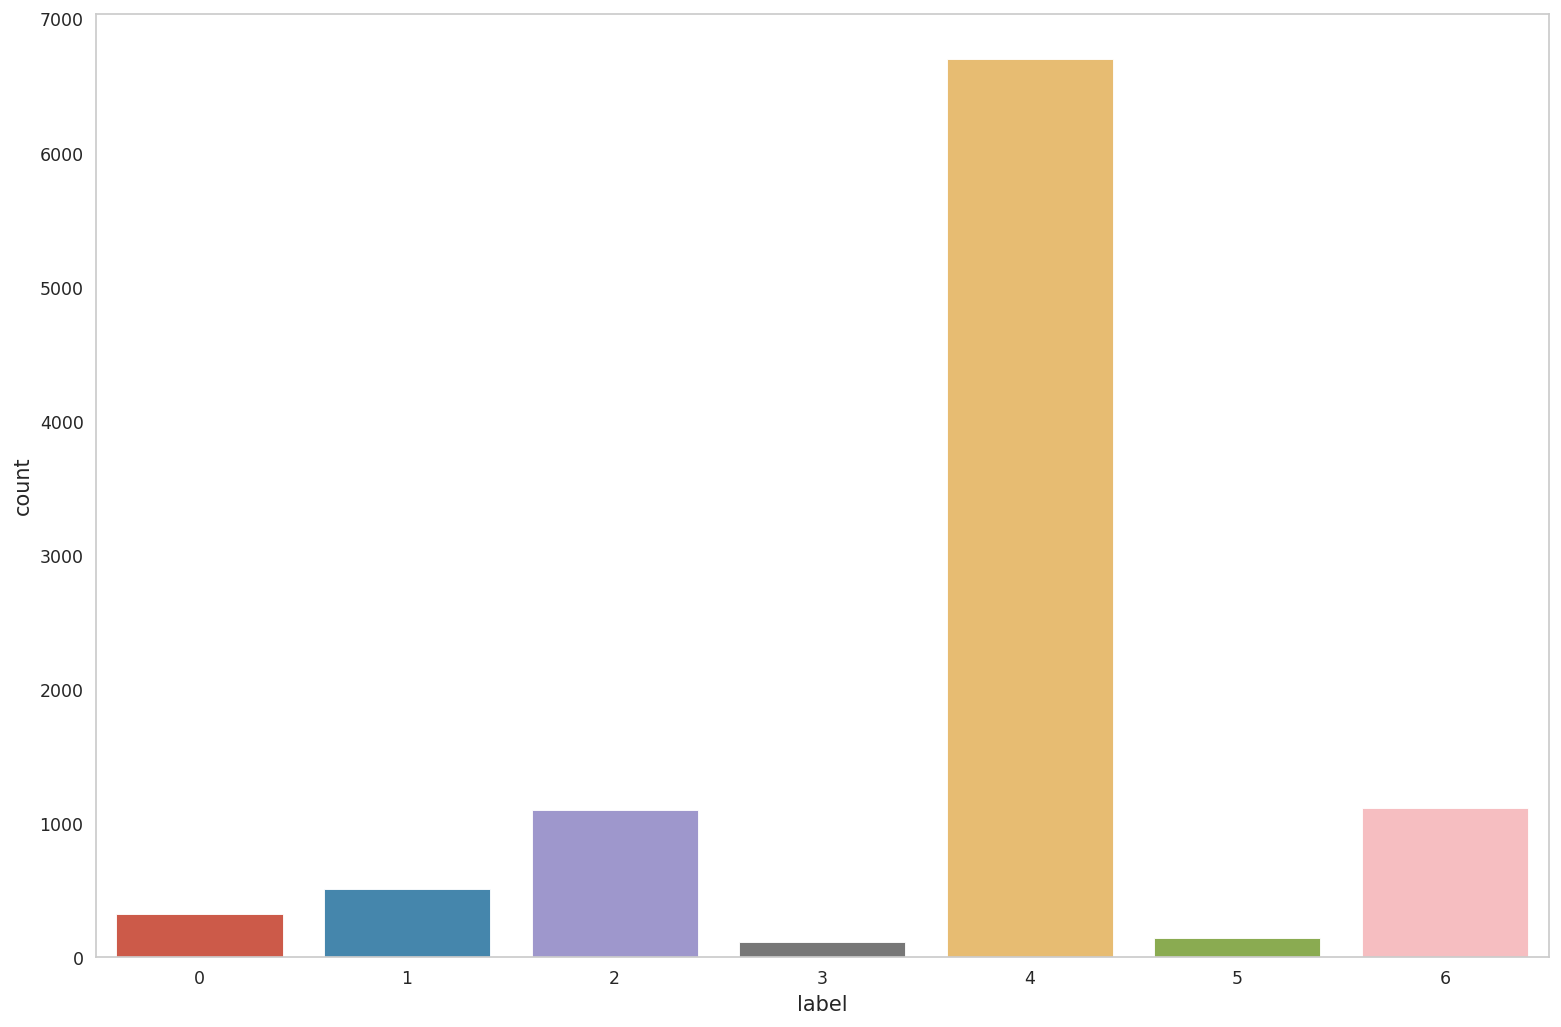

In [ ]:
sns.countplot(Label)

In [ ]:
Data.shape

(10015, 2352)

In [ ]:
strategy_over = {0:2000, 1:2000, 2:2000, 3:1000, 5:1000, 6:2000}
# Tăng cường cho các lớp tối thiểu
oversample = RandomOverSampler(sampling_strategy=strategy_over)
undersample = RandomUnderSampler(sampling_strategy = {4: 3000})
Data,Label  = oversample.fit_resample(Data,Label)

Data, Label = undersample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1,28,28,3)
print('Shape of Data :',Data.shape)

Shape of Data : (13000, 28, 28, 3)


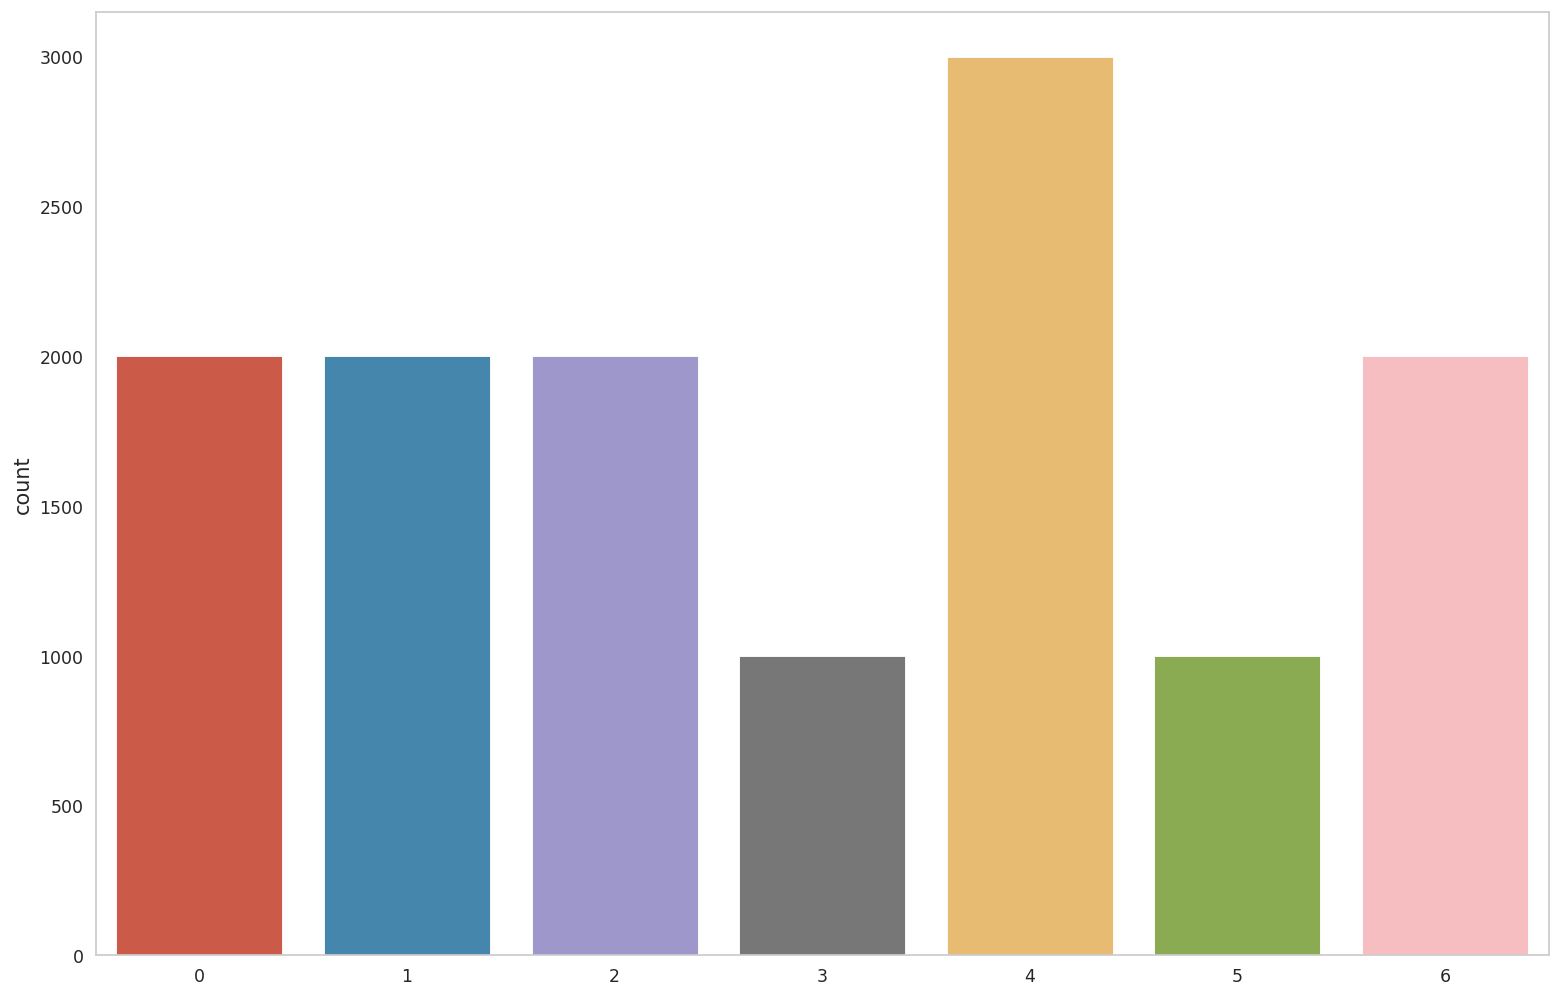

In [ ]:
sns.countplot(Label)

In [ ]:
Label = np.array(Label)
Label

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2: ('bkl', 'benign keratosis-like lesions'), 
           1: ('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [ ]:
X_train , X_valid , y_train , y_valid = train_test_split(Data , Label , test_size = 0.2 , random_state = 42, stratify=Label)
X_val, X_test, y_val, y_test = train_test_split(X_valid , y_valid , test_size = 0.5, random_state = 101, stratify=y_valid)

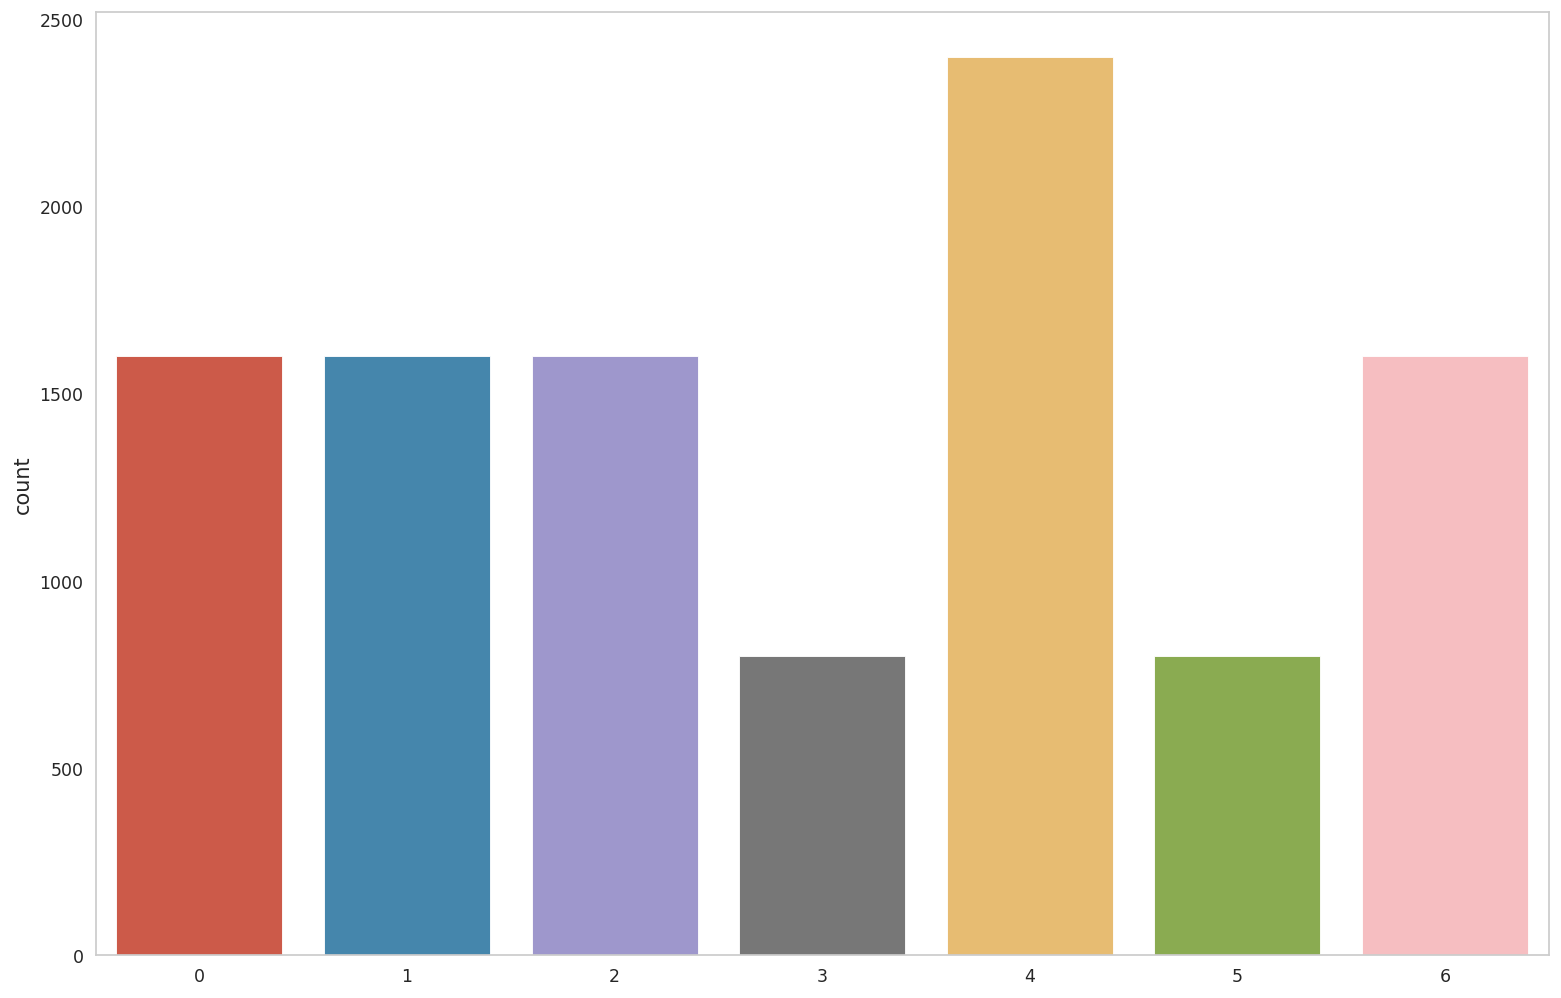

In [ ]:
sns.countplot(y_train)

In [ ]:
print(X_train.shape, 'training masks')
print(X_test.shape, 'testing masks')
print(y_train.shape, 'y training masks')
print(y_test.shape, 'y testing masks')
print(y_val.shape, 'y validation masks')

(10400, 28, 28, 3) training masks
(1300, 28, 28, 3) testing masks
(10400,) y training masks
(1300,) y testing masks
(1300,) y validation masks


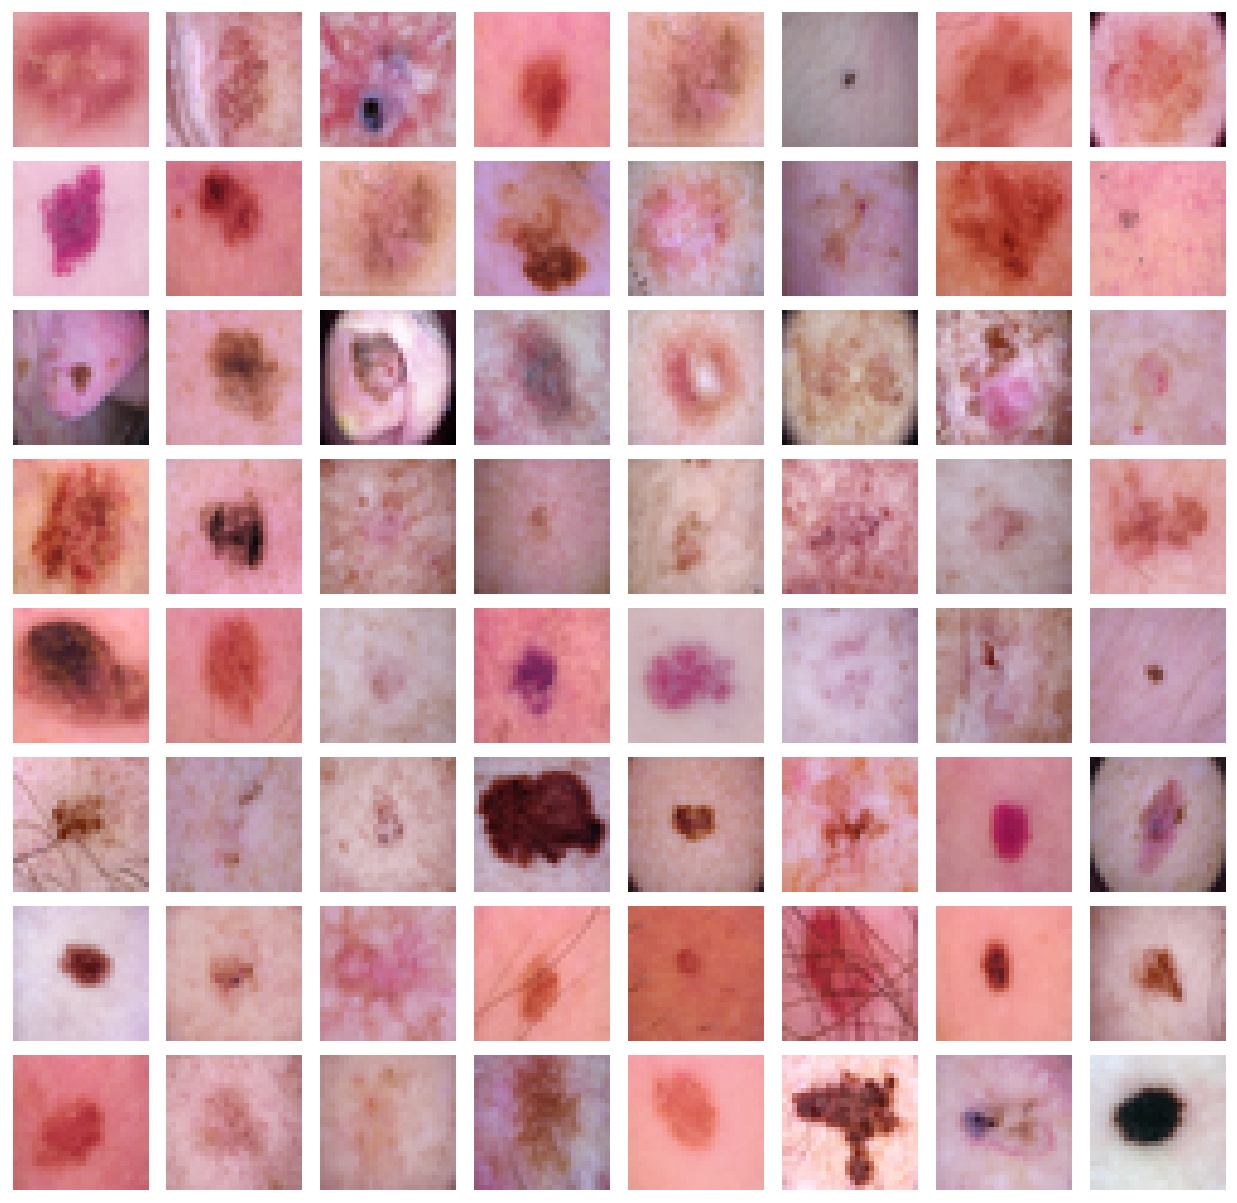

In [ ]:
fig, (ax) = plt.subplots(8, 8, figsize = (10, 10))
k = 0 
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(X_train[k].reshape(28,28,3))
        ax[i,j].axis('off')
        k = k + 1  
    plt.tight_layout()
    #ax.set_title('image')

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val =  to_categorical(y_val)

In [ ]:
print(y_train)
print(y_train.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(10400, 7)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            , factor=0.5
                                            , min_lr=0.00001)

In [ ]:
def Skin_Lesion_Model():
  input_ = keras.layers.Input(shape = [28,28,3])
  x = keras.layers.Conv2D(32 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(input_)
  x = keras.layers.MaxPooling2D()(x)

  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(64 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
  x = keras.layers.Conv2D(64 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
  x = keras.layers.MaxPooling2D()(x)

  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(128 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
  x = keras.layers.Conv2D(128 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
  x = keras.layers.MaxPooling2D()(x)

  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(256 , (3,3) , activation='relu' ,padding='same', kernel_initializer='he_normal')(x)
  x = keras.layers.Conv2D(256 , (3,3) , activation='relu' ,padding='same', kernel_initializer='he_normal')(x)
  x = keras.layers.MaxPooling2D()(x)

  flatten  = keras.layers.Flatten()(x)
  classifier = keras.layers.Dropout(rate = 0.2)(flatten)

  classifier = keras.layers.Dense(units = 256 , activation = 'relu' , kernel_initializer = 'he_normal')(classifier)
  classifier = keras.layers.BatchNormalization()(classifier)

  classifier = keras.layers.Dense(units = 128 , activation = 'relu' , kernel_initializer = 'he_normal')(classifier)
  classifier = keras.layers.BatchNormalization()(classifier)

  classifier = keras.layers.Dense(units = 64 , activation = 'relu' , kernel_initializer = 'he_normal')(classifier)
  classifier = keras.layers.BatchNormalization()(classifier) 

  classifier = keras.layers.Dense(units = 32 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_regularizer=keras.regularizers.L1L2())(classifier)
  classifier = keras.layers.BatchNormalization()(classifier) 

  classifier = keras.layers.Dense(units = 7 , activation='softmax' ,kernel_initializer="glorot_uniform" , name = 'classifier')(classifier)

  return keras.models.Model(inputs = input_  ,outputs =  classifier  )
  

In [ ]:
model = Skin_Lesion_Model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0     

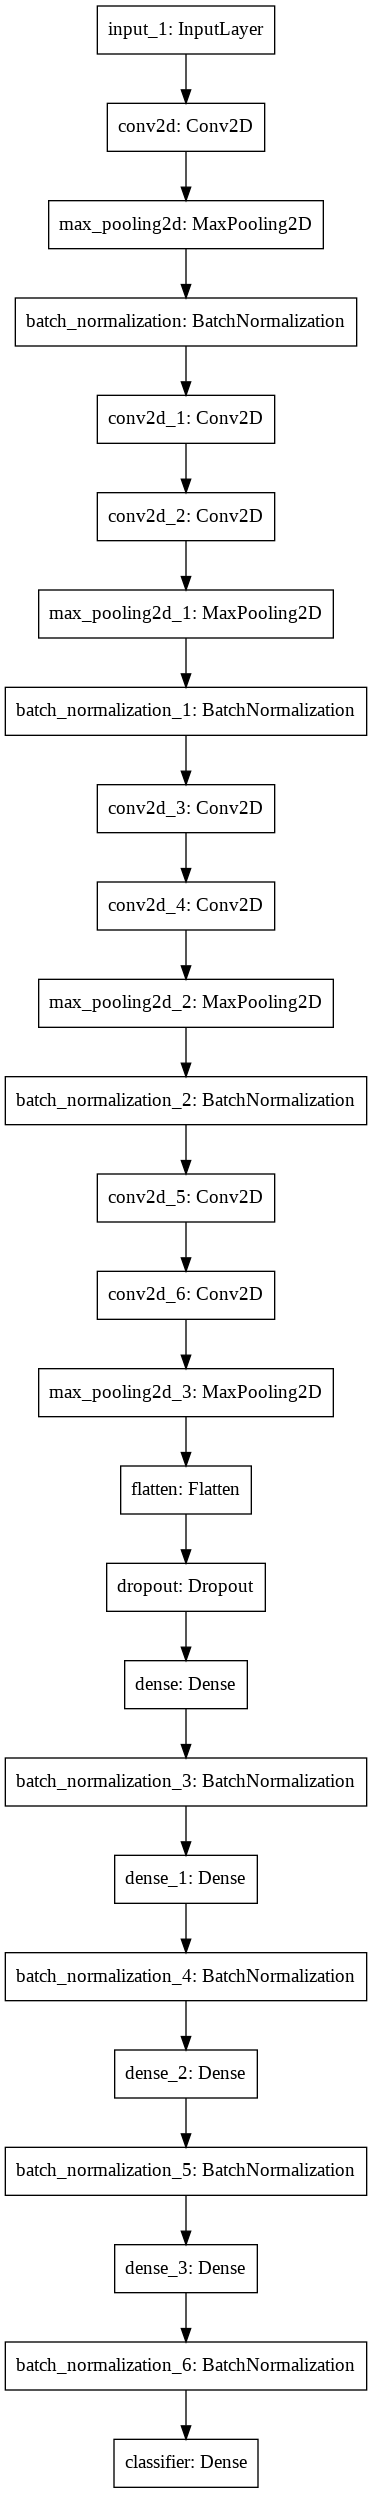

In [ ]:
keras.utils.plot_model(model)

In [ ]:
model.compile(optimizer='adam', loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[learning_rate_reduction])

Epoch 1/30
82/82 [==============================] - 72s 847ms/step - loss: 1.7039 - accuracy: 0.3800 - val_loss: 3.9223 - val_accuracy: 0.1323
Epoch 2/30
82/82 [==============================] - 69s 845ms/step - loss: 1.2066 - accuracy: 0.5307 - val_loss: 1.9918 - val_accuracy: 0.3762
Epoch 3/30
82/82 [==============================] - 69s 844ms/step - loss: 0.9690 - accuracy: 0.6345 - val_loss: 1.1676 - val_accuracy: 0.5662
Epoch 4/30
82/82 [==============================] - 69s 843ms/step - loss: 0.7545 - accuracy: 0.7235 - val_loss: 1.3207 - val_accuracy: 0.5462
Epoch 5/30
82/82 [==============================] - 69s 841ms/step - loss: 0.5985 - accuracy: 0.7799 - val_loss: 1.1833 - val_accuracy: 0.5815
Epoch 6/30
82/82 [==============================] - 69s 844ms/step - loss: 0.4914 - accuracy: 0.8167 - val_loss: 0.7792 - val_accuracy: 0.7423
Epoch 7/30
82/82 [==============================] - 69s 839ms/step - loss: 0.3955 - accuracy: 0.8551 - val_loss: 0.6598 - val_accuracy: 0.7846

In [ ]:
model.evaluate(X_test, y_test)

41/41 [==============================] - 2s 45ms/step - loss: 0.4548 - accuracy: 0.9000


[0.4548014998435974, 0.8999999761581421]

(0.0, 1.0)

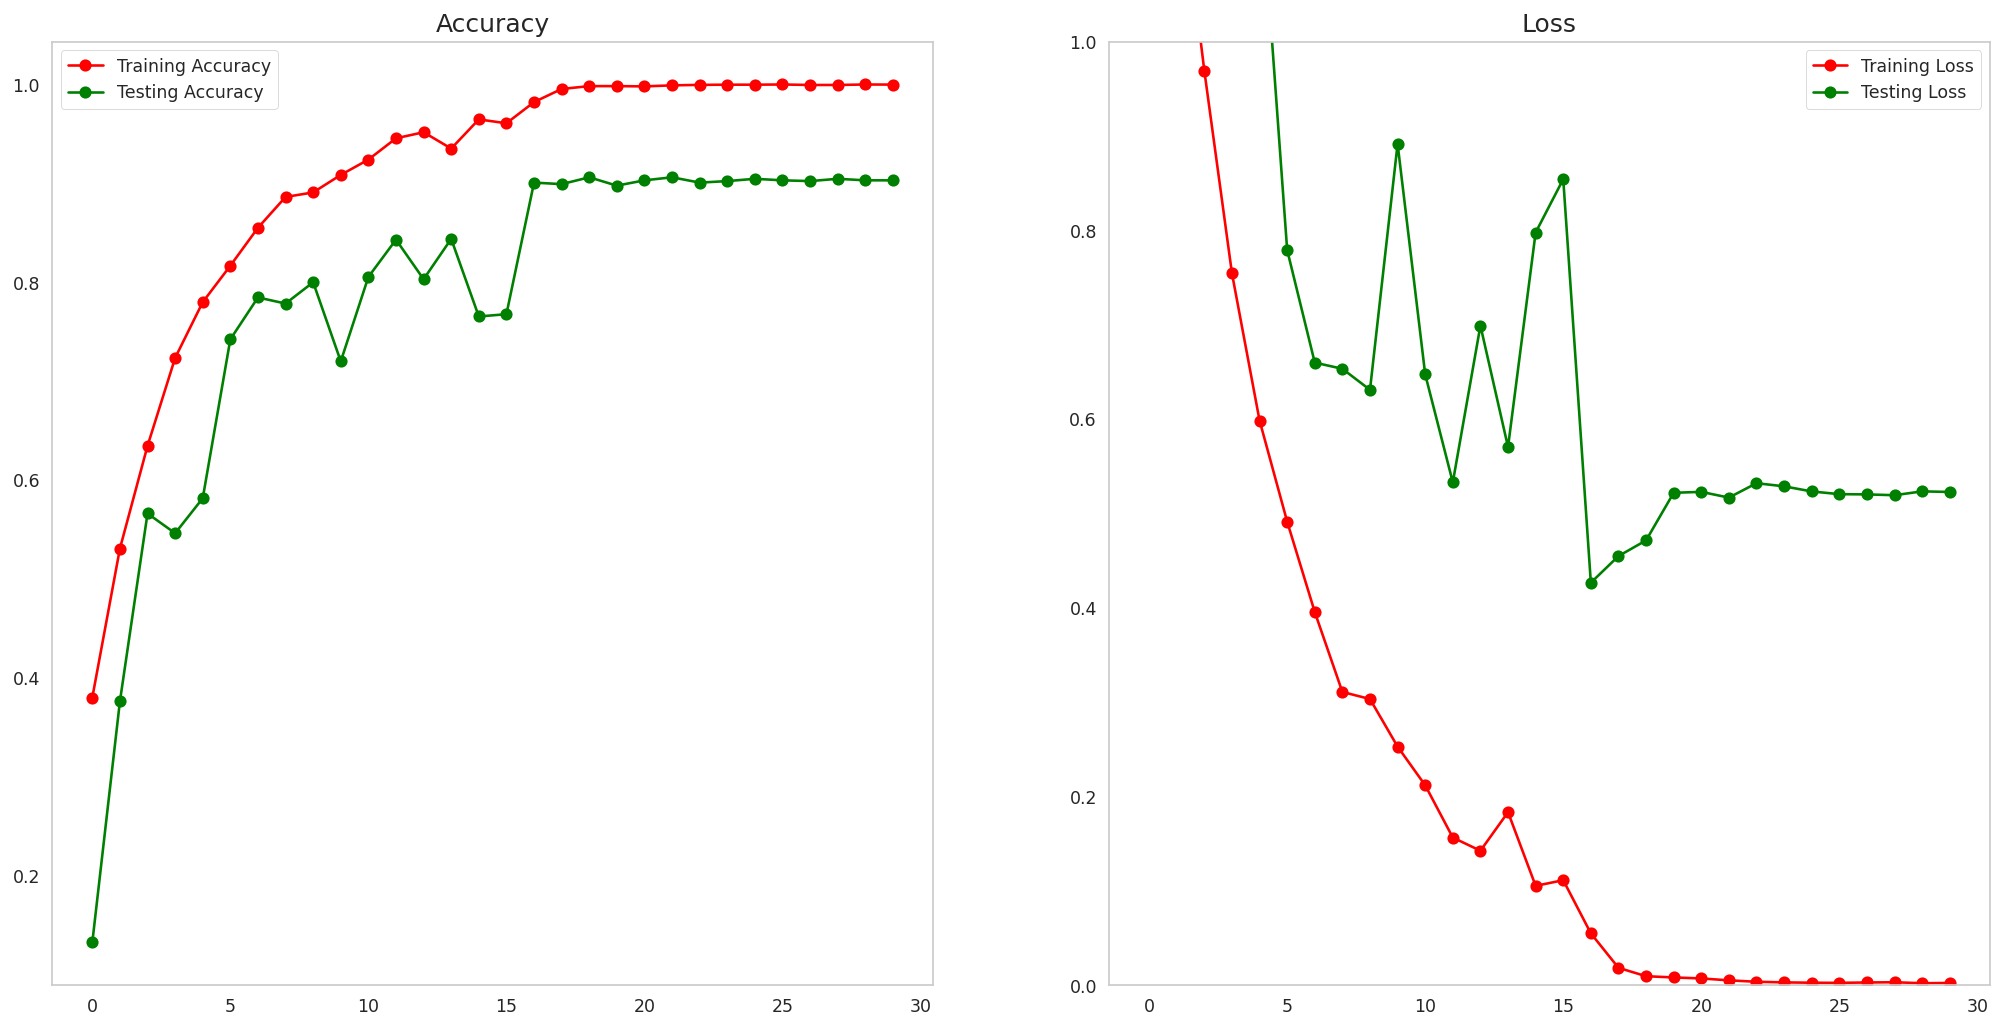

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
ax1.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
ax1.legend()
ax2.set_title('Loss')
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
ax2.legend()
ax1.set_title('Accuracy')
ax2.set_ylim(0, 1)

In [ ]:
y_pred  = model.predict(X_test).round()

In [ ]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred , target_names =target_names ))

                                                               precision    recall  f1-score   support

('akiec', 'Actinic keratoses and intraepithelial carcinomae')       0.97      1.00      0.99       200
                             ('bcc', ' basal cell carcinoma')       0.92      0.99      0.96       200
                     ('bkl', 'benign keratosis-like lesions')       0.82      0.86      0.84       200
                                     ('df', 'dermatofibroma')       1.00      1.00      1.00       100
                                  ('nv', ' melanocytic nevi')       0.90      0.79      0.84       300
              ('vasc', ' pyogenic granulomas and hemorrhage')       0.99      1.00      1.00       100
                                          ('mel', 'melanoma')       0.81      0.81      0.81       200

                                                    micro avg       0.90      0.90      0.90      1300
                                                    macro avg       0.9

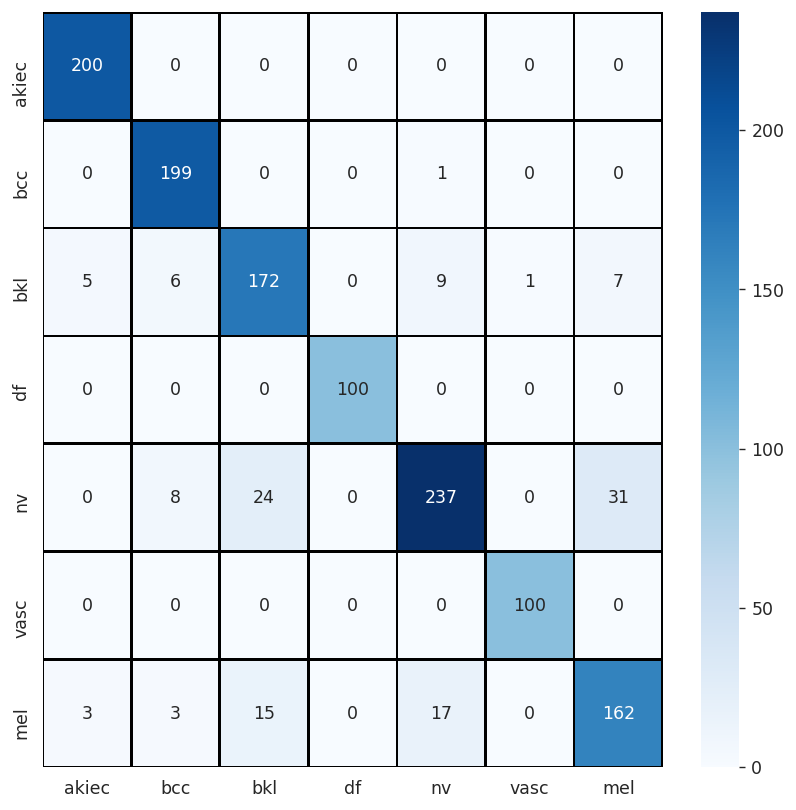

In [ ]:
cm = confusion_matrix(y_test.argmax(axis = 1) , y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = [i for i in range(7)] , columns = [i for i in range(7)])
plt.figure(figsize = (8,8))
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='', 
            yticklabels = plot_labels,
            xticklabels = plot_labels)

Text(0, 0.5, 'Fraction classified incorrectly')

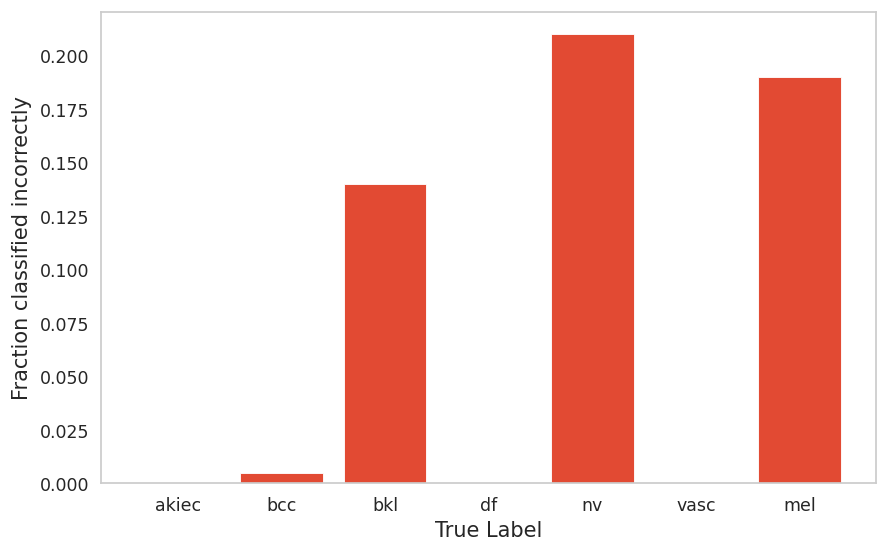

In [ ]:
label_frac_error = 1 - np.diag(cm) / np.sum(cm, axis=1)
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.bar(np.arange(7),label_frac_error)
plot_lbls = ['','akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
ax.set_xlabel('True Label')
ax.set_xticklabels(plot_lbls)
ax.set_ylabel('Fraction classified incorrectly')

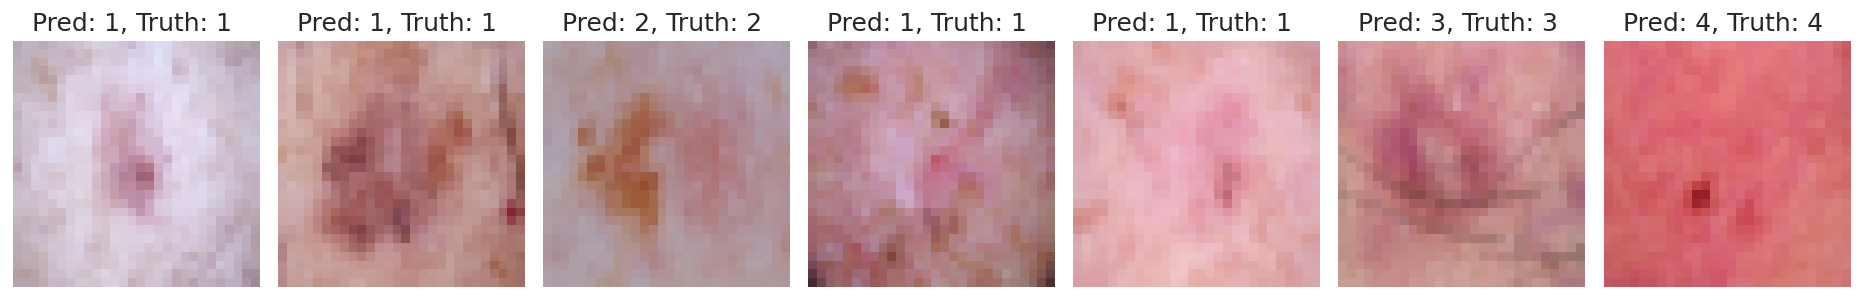

In [ ]:
correct = np.nonzero(y_pred == y_test)[0]

k = 0
for c in correct[:14]:
            plt.subplot(2,7,k+1)
            plt.imshow(X_test[k].reshape(28,28,3), interpolation='none')
            plt.title(f"Pred: {y_pred[k].argmax(axis = 0)}, Truth: {y_test[k].argmax(axis = 0)} ")
            plt.axis('off')
            plt.tight_layout()
            k += 1

In [ ]:
model.save('/content/drive/MyDrive/HAM10000 dataset/model', save_format='h5')

# TEST

In [ ]:
target_names = ["('akiec', 'Actinic keratoses and intraepithelial carcinomae')", 
                "('bcc', ' basal cell carcinoma')", 
                "('bkl', 'benign keratosis-like lesions')", 
                "('df', 'dermatofibroma')", 
                "('nv', ' melanocytic nevi')", 
                "('vasc', ' pyogenic granulomas and hemorrhage')", 
                "('mel', 'melanoma')"]

In [ ]:
#@title Default title text
def resize_img(img):
    resized_image = resize(img, (28, 28))
     # Convert the image to a 0-255 scale.
    rescaled_image = 255 * resized_image
     # Convert to integer data type pixels.
    final_image = rescaled_image.astype(np.uint8)
     # show resized image
    img = Image.fromarray(final_image, 'RGB')
    test_img  = np.array(img)
    return test_img.reshape(-1, 28, 28, 3)

def test_img_from_url(model, url):

    image_np = skimage.io.imread(url)
    test = resize_img(image_np)
    result = test_model.predict(test).round()
    return target_names[np.argmax(result)]

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.5.0
